# **Math-485: Topics in Data Science**

## **Textual Data Unit Project**

### Josh Winnes
---
## **Objective**

To produce an experimental evaluation of classifier performance on UN SDG labeled textual data. The evaluation should be conducted on a set of algorithms in combination with a set of NLP preprocessing steps, and conclude with the best performing algorithm with the associated preprocessing steps.

## **Specifications**

* prepare data as having been done in class and homework  
* write a function that will   
  * takes in a corpus (such as prepared so far) as input, and  
  * takes another parameter of “classifier\_algorithm” for the algorithm to use, the parameter settings for the algorithm should be part of the “classifier\_algorithm” parameter  
  * run the classifier with train\_test split, i.e., train on the training set and test on the test set  
  * report the metrics of precision, recall, f1\_score, and accuracy  
* run various classification algorithms on the UN SDG labeled data we have been using in class  
  * multinomial naive bayes   
  * multilayer perceptron (sklearn.neural\_network.MLPClassifier, note to use min\_df to ensure computation can be completed in reasonable time)  
  * ridge regression (sklearn.linear\_model.Ridge)  
  * combine with different preprocessing settings  
    * use count vectors vs. tfidf vectors  
    * use unigram only, bigram only, or both  
* evaluate all performance results in one table, with all configurations, bold face the numbers that give the best performance

for example, for one configuration, e.g., bigram with min\_df \= 3, the portion of table should contain

|  | MultinomialNB | MLP | Ridge |
| :---- | :---- | :---- | :---- |
| precision |  |  |  |
| recall |  |  |  |
| f1 |  |  |  |
| accuracy |  |  |  |

* for each SDG, what are the most differentiating features according to the classifier?  
* are there any overlaps between the SDG vocabularies?

## **Deliverables**

* A self contained python jupyter notebook that implements the specifications.  
* take the main text content from these pages, and feed them into your classifier and see how your model classifies them. Are the classifications reasonable? find a case where your classification is not reasonable and explain what the model does that leads to the not ideal classification.  
  [http://gianttortoise.org/en/beyond-tracking](http://gianttortoise.org/en/beyond-tracking)  
  [https://www.dhs.gov/blue-campaign/what-human-trafficking](https://www.dhs.gov/blue-campaign/what-human-trafficking)  
  [https://www.dol.gov/agencies/odep/program-areas/individuals/older-workers](https://www.dol.gov/agencies/odep/program-areas/individuals/older-workers)  
  [https://michigantoday.umich.edu/2022/08/26/positively-breaking-the-age-code/](https://michigantoday.umich.edu/2022/08/26/positively-breaking-the-age-code/)

## **Important note (to help reduce computation time if that is an issue)**

* when the classification takes too long to run on your computer (most likely they will on this project), set min\_df in the vectorizer to reduce the vocabulary size, which will reduce the matrix size drastically.   
* if you choose to run experiments on fewer number of SDGs, please be sure to include SDG 8 in your collection, and choose several others among  \[2,3,4,8,9,10,14,15,16\], to show your work on multiple classes

---

### **Scraping the Websites using Beautiful Soup 4**
This is necessary in order to get the text data into a dataframe so we can actually process the text in the website using our sklearn models later

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# List of URLs to scrape
urls = [
    "http://gianttortoise.org/en/beyond-tracking",
    "https://www.dhs.gov/blue-campaign/what-human-trafficking",
    "https://www.dol.gov/agencies/odep/program-areas/individuals/older-workers",
    "https://michigantoday.umich.edu/2022/08/26/positively-breaking-the-age-code/"
]

# Dictionary that links URLs to HTML Class names to locate the main text
class_name_dict = {
    "http://gianttortoise.org/en/beyond-tracking":'elementor-container elementor-column-gap-default',
    "https://www.dhs.gov/blue-campaign/what-human-trafficking":'field field--name-body field--type-text-with-summary field--label-hidden field__item',
    "https://www.dol.gov/agencies/odep/program-areas/individuals/older-workers":'field field--name-field-p-text field--type-text-long field--label-hidden clearfix',
    "https://michigantoday.umich.edu/2022/08/26/positively-breaking-the-age-code/":'post'
}

# Function to extract the main text from a webpage
def extract_main_text(url, class_name):
    response = requests.get(url)

    soup = BeautifulSoup(response.content, "html.parser")

    # Extract main text        
    divs = soup.find_all('div', class_ = class_name)
    text = ''
    for div in divs:
        p_elements = div.find_all('p')
        li_elements = div.find_all('li')
        for p in p_elements:
            text += p.get_text() + " "
        for li in li_elements:
            text += li.get_text() + ' '

    return text

data = {"url": [], "text": []}

for url in urls:
    text = extract_main_text(url, class_name_dict.get(url))
    data["url"].append(url)
    data["text"].append(text)

# Create a DataFrame
df = pd.DataFrame(data)

df.head()

,url,text
0,http://gianttortoise.org/en/beyond-tracking,Having discovered some of the mechanisms gover...
1,https://www.dhs.gov/blue-campaign/what-human-t...,"Human trafficking involves the use of force, f..."
2,https://www.dol.gov/agencies/odep/program-area...,"Today, a confluence of factors is prompting Am..."
3,https://michigantoday.umich.edu/2022/08/26/pos...,"Scientist/author Becca Levy, BA ’87, is a prof..."


### **Importing the training data**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns 
from matplotlib import pyplot as plt
import matplotlib as mpl
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from langdetect import detect

In [3]:
data_dir = "/Users/joshwinnes/Library/Mobile Documents/com~apple~CloudDocs/Wheaton College/fall 2024/topics in data science/data/"
sdg_names = pd.read_csv(data_dir + "sdg_name_definition.csv")

text_file_name = "osdg-community-data-v2024-04-01.csv"
text_df = pd.read_csv(data_dir + text_file_name,sep = "\t",  quotechar='"')
text_df.drop(text_df.columns.values[0],axis = 1, inplace=True)
text_df = text_df.query("agreement > 0.5 and (labels_positive - labels_negative) > 2").reset_index(drop=True)
text_df["lang"] = text_df["text"].apply(lambda x: detect(x))
text_df = text_df.query("lang == 'en'")
text_df.reset_index(inplace=True,drop=True)

In [4]:
corpus = text_df.text
count_vectorizer = CountVectorizer(stop_words='english')
count_vectorizer.fit(corpus)
count_vector = count_vectorizer.transform(corpus).toarray() 
count_vector_df = pd.DataFrame(count_vector, columns=count_vectorizer.get_feature_names_out())
term_freq = pd.DataFrame({"term": count_vector_df.columns.values, "freq" : count_vector_df.sum(axis=0)})
term_freq.sort_values(by="freq", ascending=False)

,term,freq
countries,countries,8494
women,women,6017
development,development,5889
public,public,4819
social,social,4755
...,...,...
pahang,pahang,1
paging,paging,1
escapees,escapees,1
pagers,pagers,1


In [5]:
corpus = text_df.text
sdg_num = text_df.sdg
X_train, X_test, y_train, y_test = \
    train_test_split(corpus, sdg_num, test_size=0.20, random_state=11)
    
X_train_count_vector = count_vectorizer.transform(X_train) 
X_test_count_vector = count_vectorizer.transform(X_test) 

### **Training the Models**

### Multinomial Naive Bayes

### Multilayer Perceptron

### Ridge Regressor

In [6]:
from sklearn.linear_model import RidgeClassifierCV

After training all the models, it looks like the MLP Classifier performed the best. Typically, I'd then use GridsearchCV to fine tune the MLP Classifier to get an even better one, but that will take too long. So, since the RidgeClassifier only scored marginally lower than the MLP Classifier, but has a way shorter training time, I'll move forward with the RidgeClassifier.

### **Fine Tuning the Model**

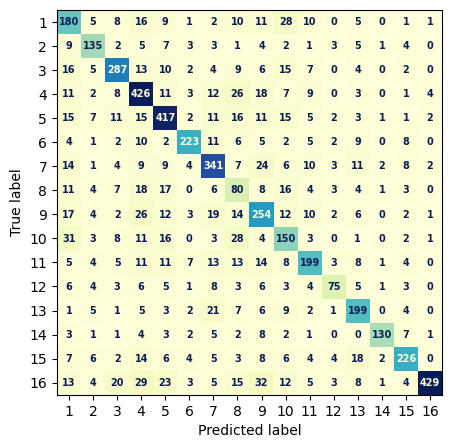

In [8]:
better_ridge_clf = RidgeClassifierCV(
    alphas = [0.093,0.095,0.097],
    cv = 5,
    scoring = 'accuracy'
)

better_ridge_clf.fit(X_train_count_vector, y_train)

y_pred = better_ridge_clf.predict(X_test_count_vector)
fig, ax = plt.subplots(figsize=(15, 5))
font = {'family': 'sans-serif', 'weight': 'heavy','size': 7,}
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, text_kw=font, ax=ax, cmap=mpl.colormaps["YlGnBu"],colorbar=None)

In [9]:
print(metrics.classification_report(y_test, y_pred, digits = 4))
print(better_ridge_clf.alpha_)

              precision    recall  f1-score   support

           1     0.5248    0.6272    0.5714       287
           2     0.7068    0.7297    0.7181       185
           3     0.7736    0.7553    0.7643       380
           4     0.6893    0.7874    0.7351       541
           5     0.7433    0.7809    0.7616       534
           6     0.8577    0.7690    0.8109       290
           7     0.7271    0.7495    0.7381       455
           8     0.3333    0.4396    0.3791       182
           9     0.6062    0.6615    0.6326       384
          10     0.5119    0.5747    0.5415       261
          11     0.7133    0.6503    0.6803       306
          12     0.7426    0.5639    0.6410       133
          13     0.6886    0.7481    0.7171       266
          14     0.9286    0.7647    0.8387       170
          15     0.8071    0.7175    0.7597       315
          16     0.9728    0.7079    0.8195       606

    accuracy                         0.7084      5295
   macro avg     0.7079   

At this point, changing the alpha isn't doing anything anymore so I'm happy with this classifier.

In [10]:
RIDGECLASSIFIER = better_ridge_clf

### **Preparing the text from the websites**

In [11]:
text_to_predict = df.text
text_to_predict_transformed = count_vectorizer.transform(text_to_predict)

RIDGECLASSIFIER.predict(text_to_predict_transformed)

array([5, 7, 8, 5])

In [13]:
sdg_names

,sdg,sdg_name,sdg_definition
0,1,No Poverty,End poverty in all its forms everywhere
1,2,Zero Hunger,"End hunger, achieve food security and improved..."
2,3,Good Health and Well Being,Ensure healthy lives and promote well-being fo...
3,4,Quality Education,Ensure inclusive and equitable quality educati...
4,5,Gender Equality,Achieve gender equality and empower all women ...
5,6,Clean Water and Sanitation,Ensure availability and sustainable management...
6,7,Affordable and Clean Energy,"Ensure access to affordable, reliable, sustain..."
7,8,Decent Work and Economic Growth,"Promote sustained, inclusive and sustainable e..."
8,9,"Industry, Innovation and Infrastructure","Build resilient infrastructure, promote inclus..."
9,10,Reduced Inequalities,Reduce inequality within and among countries
